# Neural Population with RL-STDP

#### A network of 1000 cortical spiking neurons.
    A random group of 50 excitatory neurons (S), representing the input.
    This population is made up of 200 inhibitory neurons and 800 excitatory neurons. In this network,communication is random with a constant probability. We consider that n group of 20 excitatory neurons as output,Then, by producing a different time pattern and using reinforcement learning in the network, we must learn that one of the categories will be more active.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [2]:
def population_activity(I_init, gl, Cm, num, prob_fixnum,n):
    ######### Constants
    U_rest      =   -0.065                  # restint membrane potential [U]
    U_reset     =   -0.065
    thresh  =   -0.050                      # spiking threshold [U]
    tau =  Cm/gl
    A_plus = 2                          #amplitude parameter A ± ( w ) ,we consider this constant!
    A_neg = -1.5
    tau_plus = 0.0002
    tau_neg =  0.0002                   #tau for stdp rule
    tau_c = 0.01
    tau_d = 0.002    
  

    ######### Setup
    # TIME
    T       =   0.400                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    # VOLTAGE
    U       =   np.empty((1000,len(time)))  # array for saving Voltage history
    U[:,0]    =   U_rest                    # set initial to resting potential
    
    # CURRENT
    I_init = I_initial(I_init=I_init, time=time, num = num)
    I = np.zeros((1000,len(time)))

    ######### Measurements
    spikes_inp = [[0] for i in range(50)]
    time_pt = time_pattern(n)
    spikes = np.zeros((1000,len(time)))              # counter for number of spikes
    activity = np.zeros((1000,len(time))) 
    act = []
    mark = np.zeros((1000,len(time)))
    W, sparse, Tau = weights(prob_fixnum, A_plus, A_neg, tau_plus, tau_neg) #set weights for the connection
    C = np.zeros((1000,1000))
    D = np.zeros((1000,1000))
    S = np.zeros((1000,1000))
    S = W
    ######### Simulation
    cnt = 0
    for i in range(1,len(time)):
        
        if(i% 550==0): cnt = randint(0,550)%n
        for j in range(0,50):
            if(i% 550 == 0):  U[j][i-1] = U_rest
            stdp , da = np.zeros(1000), np.zeros(1000)
            spikes[j][i] = spikes[j][i-1]
            
            #compute current
            I[j][i]= I_init[i]*bool(i%550 > time_pt[cnt][j]) + I[j][i]
            
            # use " tau.(du/dt) = -(U(t) -U_rest) + R.I(t))" to get this equation
            U[j][i] = (((U_rest - U[j][i-1]) + I[j][i]/gl)*dt)/tau + U[j][i-1]
            
            # use " dc/dt = - c/τ-c + STDP (τ)δ( t − (t-pre / post) )" to get this equation
            if(U[j][i] > thresh):
                for l in range(1000):
                    if(spikes[l,i-1]>0):
                        stdp[l] = np.exp(-1*abs(spikes[l,i-1] - time[i])/Tau[l,j])*sparse[l,j]*10000
            C[j,:] = (-C[j,:]/tau_c + stdp)*dt + C[j,:]
            
            # use " dd/dt = − d/τ-d + + DA(t)" to get this equation
            if(mark[j][i] == 1):
                for l in range(1000):
                    if(spikes[l,i-1]>0 and abs(spikes[l,i-1]- time[i])<0.01):
                        da[l] = np.exp(-1*abs(spikes[l,i-1] - time[i]))/Tau[l,j]*10*sparse[l,j]
            D[j,:] = (-D[j,:]/tau_d + da)*dt + D[j,:]
            
            # in case we exceed threshold
            if U[j][i] > thresh:
                U[j][i-1] = 0.04      # set the last step to spike value
                U[j][i] = U_reset     # current step is resting membrane potential
                spikes[j][i] = time[i] # count spike
                activity[j][i] = 1
                spikes_inp[j].append(time[i])
                if(i+5+j<len(time)):mark[j][i+5+j] = 1
                act.append([i,j])
                if(i< 19997):
                    add_amount = I_values(j,i,I_init,time,spikes, sparse, S)
                    I[:,i+1:i+5] = I[:,i+1:i+5] + add_amount
                    
            # use " ds/dt = cd" to get this equation
            S[j,:] = C[j,:]*D[j,:]*dt + S[j,:]        
                    
        for j in range(50,1000):
            stdp , da = np.zeros(1000), np.zeros(1000)
            spikes[j][i] = spikes[j][i-1]
            
            # use " tau.(du/dt) = -(U(t) -U_rest) + R.I(t))" to get this equation
            U[j][i] = (((U_rest - U[j][i-1]) + I[j][i]/gl)*dt)/tau + U[j][i-1]
            
            # use " dc/dt = - c/τ-c + STDP (τ)δ( t − (t-pre / post) )" to get this equation
            if (U[j][i] > thresh): 
                stdp = np.exp(-1*abs(spikes[:,i-1] - time[i])/Tau[:,j])*sparse[:,j]*10000
            C[j,:] = (-C[j,:]/tau_c + stdp)*dt + C[j,:]
            
            # use " dd/dt = − d/τ-d + + DA(t)" to get this equation
            if mark[j][i] == 2 :
                for l in range(1000):
                    if(spikes[l,i-1]>0 and abs(spikes[l,i-1]- time[i])<0.01):
                        da[l] = np.exp(-1*abs(spikes[l,i-1] - time[i]))/Tau[l,j]*10*sparse[l,j]
                
            D[j,:] = (-D[j,:]/tau_d + da)*dt + D[j,:]
             
            # in case we exceed threshold
            if U[j][i] > thresh:
                U[j][i-1] = 0.04      # set the last step to spike value
                U[j][i] = U_reset     # current step is resting membrane potential
                spikes[j][i] =time[i] # count spike
                activity[j][i] = 1
                if(i+7+j<len(time)):mark[j][i+7+j] = 2
                act.append([i,j])
                if(i< 19997):
                    add_amount = I_values(j,i,I_init,time,spikes, sparse, S)
                    I[51:1000,i+1:i+5] = I[51:1000,i+1:i+5] + add_amount[51:1000,:]
                    
            # use " ds/dt = cd" to get this equation
            S[j,:] = C[j,:]*D[j,:]*dt + S[j,:]            
             
    return act , I, spikes_inp, S, activity

#compute the initial current
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:20001] = I_init
    I1 = []
    I2 = []

    #Setting the initial current_ I1 
    for i in range(0, len(time)):
        
        var = gauss(I_init,I_init*0.1)
        I1.append(var)
    
    #Setting the initial current_ I2
    for i in range(0, len(time)):
        
        var = ((math.cos(i/100)+1)/4)*((math.sin(i/300)+1)/4)*(gauss(0,0.4*I_init))+I_init
        I2.append(var)
   
    I = [I0,I1,I2]
    return I[num-1]


#compute the effect of presynaptic neuron's spike to their postsynaptic neurons!            
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, sparse=None, W=None ,tau_I=0.003):
    #use w_ji*epsilon(s) where epsilon(s) = (s/tau).exp(1-(s/tau)) ;s=t - t_spike > 0
    exp1 = (time[i+1:i+5] - spikes[j][i])/tau_I
    exp2 =  np.exp(1-exp1)
    exp3 =  exp1*exp2
    I_inp = np.dot(W[j,:].reshape(1000,1),exp3.reshape(1,4))
    
    return I_inp


#compute the weights of connectivity due to type of connectivty!
def weights(prob_fixnum = 1, A_plus=1, A_neg=-1, tau_plus=0.0003, tau_neg=0.001): 
    w = np.zeros((1000,1000))
    w = abs(np.random.normal(3,1,size=(1000,1000)))
    w = (w+w.T )/2
    w[800:1000,:] = -1*w[800:1000,:]
    w[0:50,0:50] = 0 
    for i in range(1000): w[i,i]=0
        

    A = sparse.random(1000, 1000, density=prob_fixnum/2, data_rvs=np.ones).toarray()
    A = A+A.T
    A=np.logical_or(A,A.T)
    B=np.ones((1000,1000))
    w = w*A/(prob_fixnum*1000)
    A[0:50,0:50] = 0
    for i in range(1000):
        A[i,i:1000] = A[i,i:1000]*A_plus
        A[i:1000,i] = A[i:1000,i]*A_neg
        B[i,i:1000] = B[i,i:1000]*tau_plus
        B[i:1000,i] = B[i:1000,i]*tau_neg
    return w,A,B
    
    
    

def time_pattern(n):
    pattern = np.zeros((n,50))
    for i in range(n):
        tp= np.random.randint(10,size=(1,50//n))*40
        for j in range(50):
            pattern[i][j] = tp[0][j%(50//n)]
    return pattern

    

In [3]:
def act_of_ensemble(act = None, time=None, n=10):
    
    ensemble=np.zeros((n,len(time)))
    for i in range(n):
        ensemble[i] = np.sum(act[1+50*(i+1):20+50*(i+1),:], axis=0) 
        
    return ensemble

def plot_ens(act = None, num = 0 ):    
    ens_activity = []
    for j in range(len(act[num])):
        if(act[num][j]>0): ens_activity.append([j,act[num][j]])
    ens_activity = np.array(ens_activity)            
    return ens_activity



def simul_pop(I_init ,gl_init ,Cm_init, num, prob_fixnum, n):
    
    # TIME
    T       =   0.400                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]

    
    act , I, spike_time,W,activity= population_activity(I_init, gl_init, Cm_init, num, prob_fixnum, n)
    ensemble = act_of_ensemble(activity, time, n)
    act = np.array(act)
  
    color = np.where(act[:,1]>799,'r','b')
    ###ploting
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("input layer neurons", figsize=(20, 10))
    colors1 = ['C{}'.format(i) for i in range(50)]
    plt.title("spike raster plot")
    plt.eventplot(spike_time, color=colors1)
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    ###ploting

    fig = plt.figure("Population activity of neurons", figsize=(20, 8))
    plt.title("Population activity of neurons")
    plt.scatter(act[:,0],act[:,1],marker='o',c = color , s=2)
    plt.ylabel("Number of neurons")
    plt.xlabel("Time [s]")
    
    fig = plt.figure("activity of ensembles", figsize=(14, 6))
    plt.title("activity of ensembles")
    
    for i in range(n):
        ens_act = plot_ens(ensemble,i)
        plt.plot(ens_act[:,0], ens_act[:,1], label="activity")
           

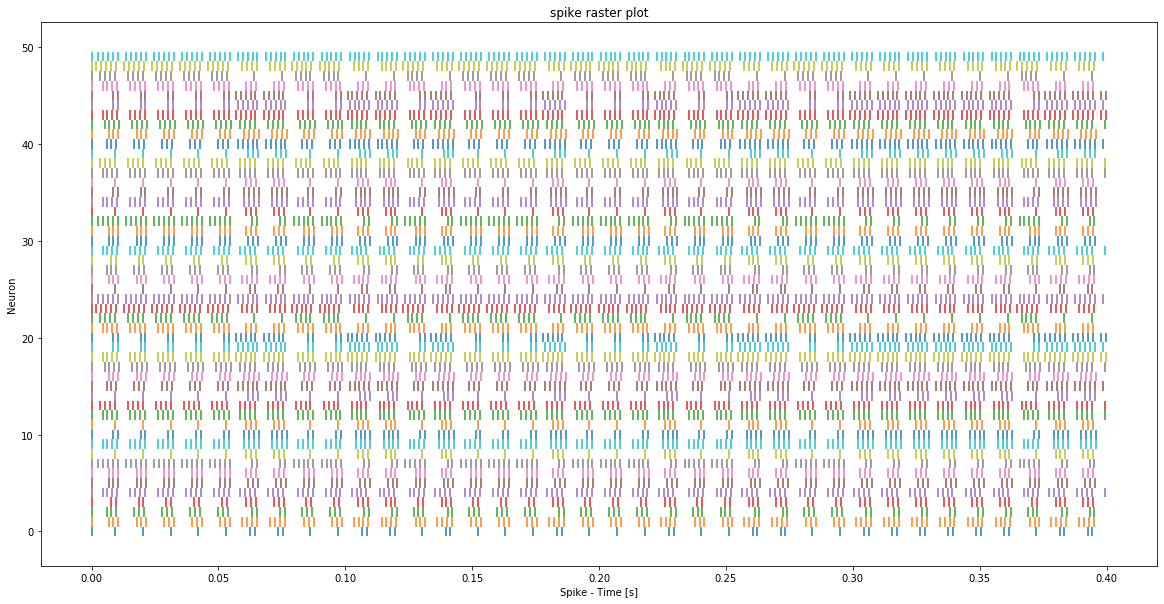

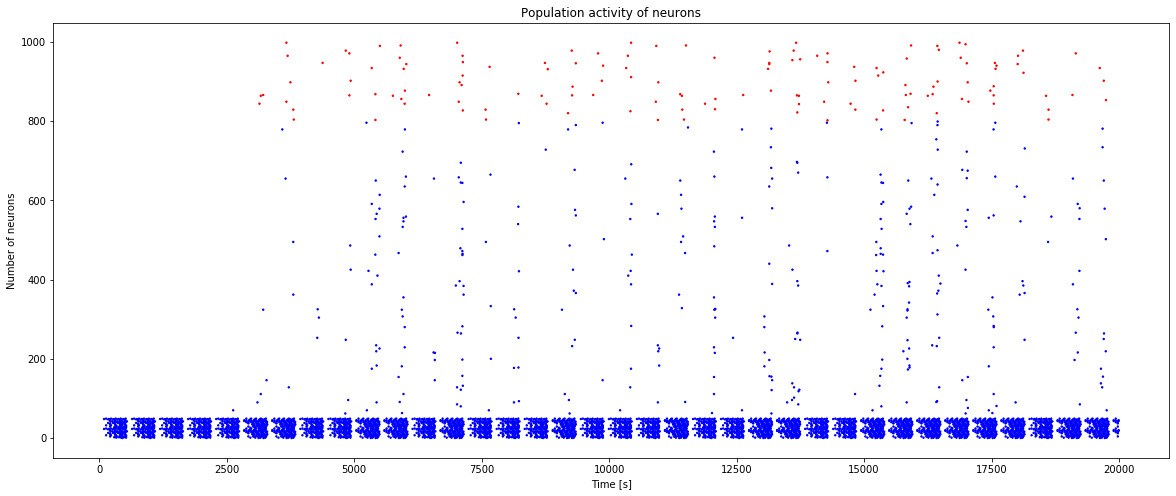

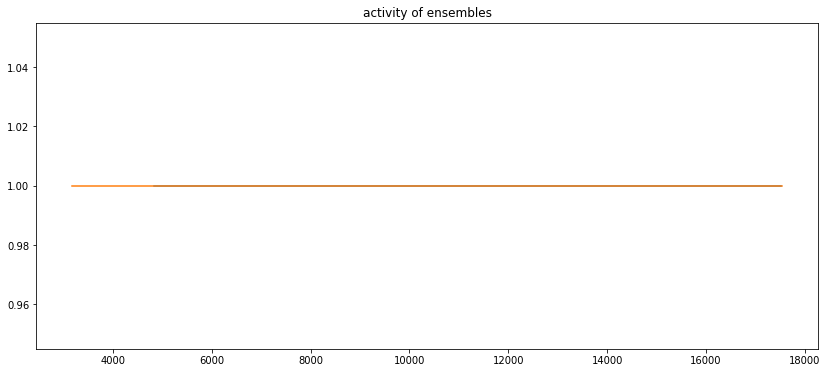

In [4]:
simul_pop(0.008 ,0.016,0.001 ,1, 0.1, 2)            

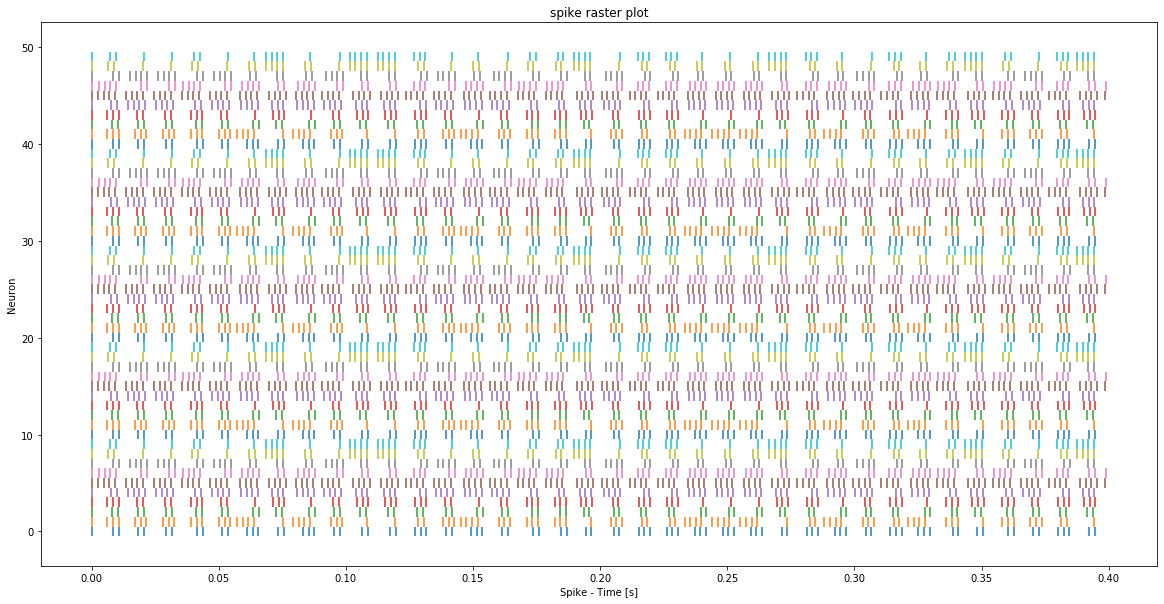

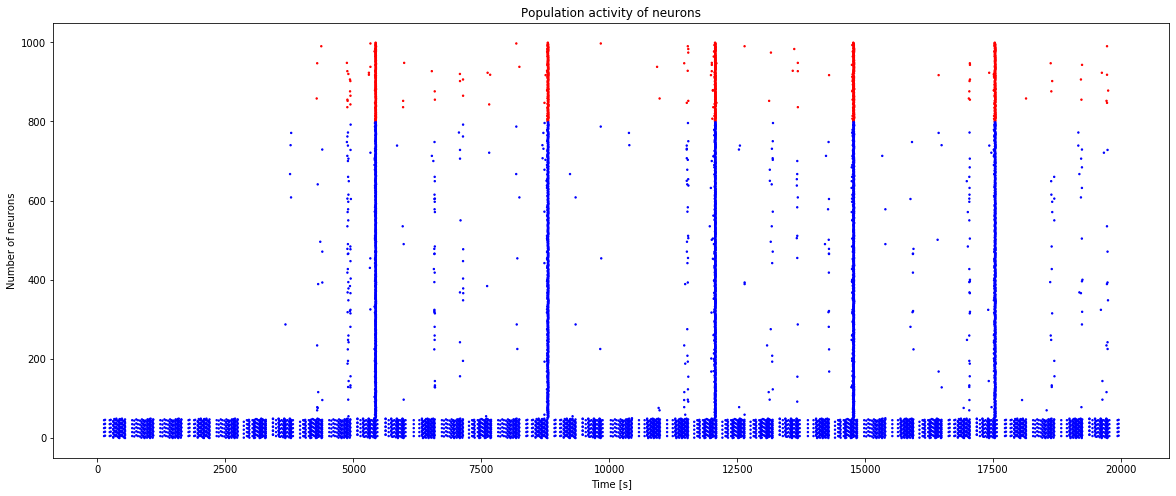

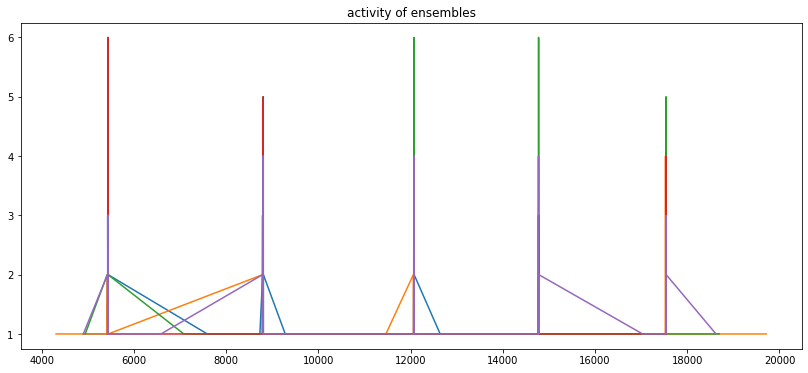

In [7]:
simul_pop(0.007 ,0.016,0.001 ,1, 0.25, 5)            

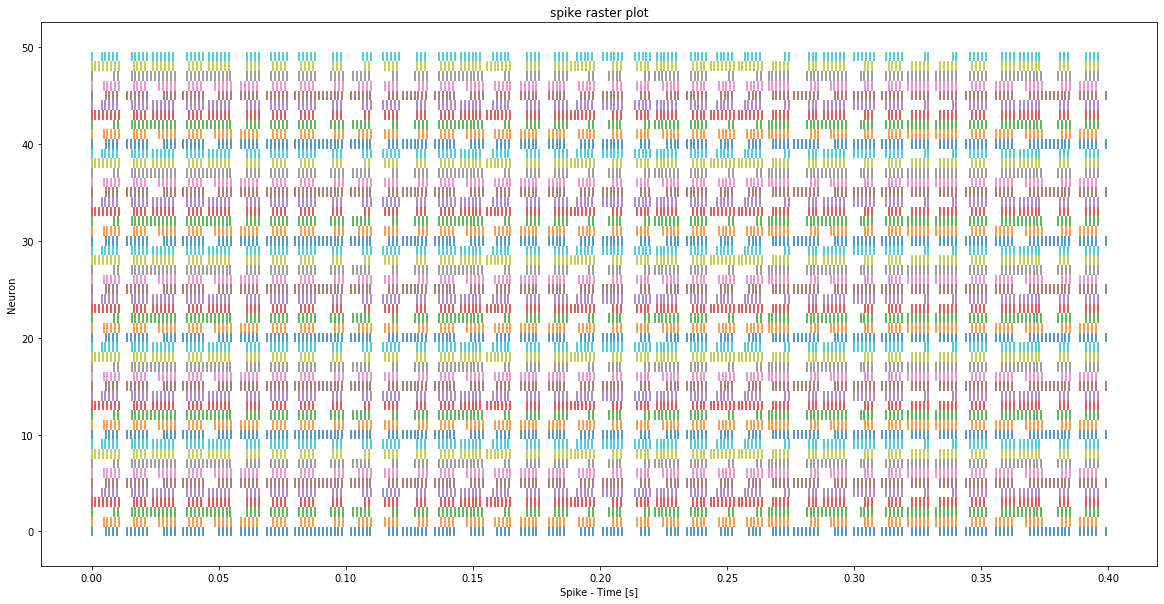

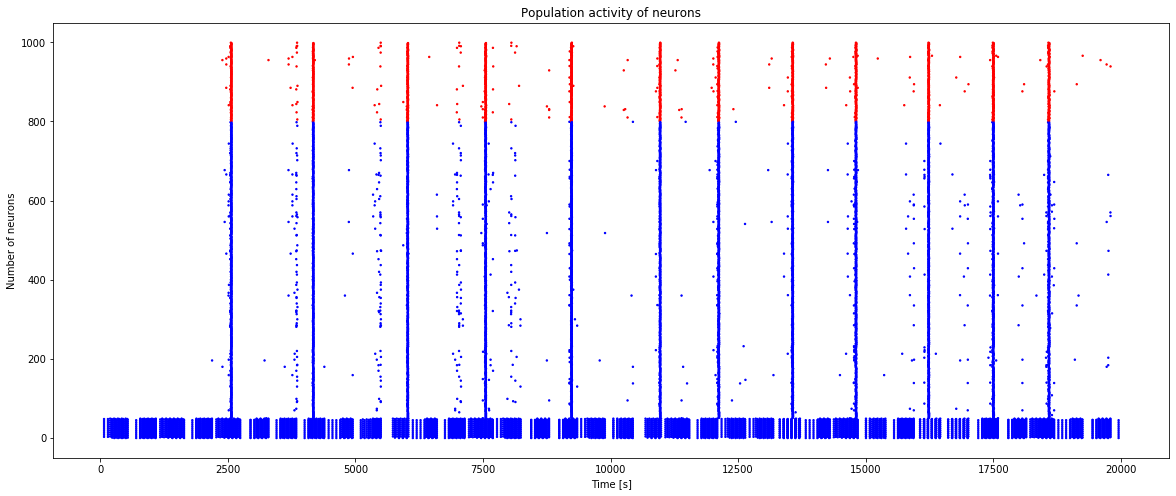

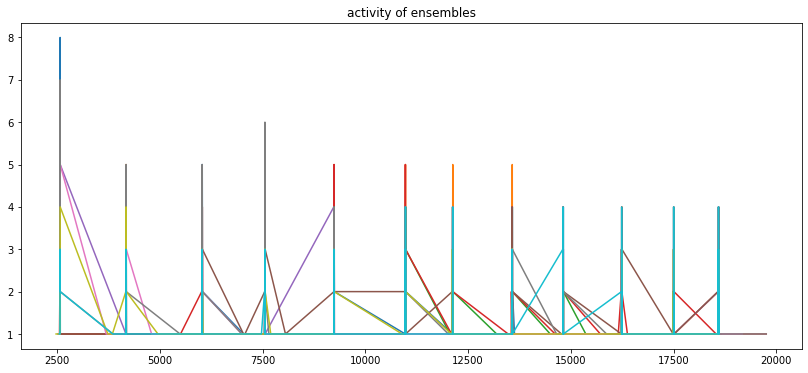

In [4]:
simul_pop(0.01 ,0.016,0.001 ,1, 0.5, 10)            

Sharare Zolghadr (610395109)                                                                                  
Computational Neuroscience